Нужно решить задачу классификации рукописных цифр на датасете mnist https://www.kaggle.com/datasets/hojjatk/mnist-dataset . Правила будут следующие:
- нужно представить решение в виде нейронной сети, написанной на numpy, и обученной с помощью алгоритма градиентного спуска.
- нейронная сеть должна состоять из двух линейных слоев, активаций relu и softmax, и mse лосса.
- нельзя пользоваться автоградиентом (pytorch, numpy). Градиенты должны считаться вручную по алгоритму обратного распространения ошибки, используя аналитические формулы производных.
- решение считается валидным, если оно достигает аккураси больше 50%.
- я не против, если в этой домашке вам будет помогать чат гпт.
Критерии оценивания:
- нейронная сеть содержит два линейных слоя, активации релу и софтмакс, производные посчитаны без ошибок - 10 баллов
- за каждый неимплементированный слой вычитается 1 балл
- в качестве простого варианта, на 6 баллов можно сделать реализацию просто одного линейного слоя, обученного без градиентного спуска любым методом оптимизации в scipy.optimize.minimize

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torch

/opt/python/envs/default/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# преобразования над датасетом
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

# датасет
data_train = torchvision.datasets.MNIST(root="./data/notebook_files/",
                                        train=True,
                                        download=True,
                                        transform=transforms
                                       )

# загрузчик данных для обучения
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=20,
                                           num_workers=5,
                                           pin_memory=True
                                          )

Extracting ./data/notebook_files/MNIST/raw/train-images-idx3-ubyte.gz to ./data/notebook_files/MNIST/raw

Extracting ./data/notebook_files/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/notebook_files/MNIST/raw

Extracting ./data/notebook_files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/notebook_files/MNIST/raw

Extracting ./data/notebook_files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/notebook_files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5850899.50it/s]
/opt/python/envs/default/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
data_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/notebook_files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

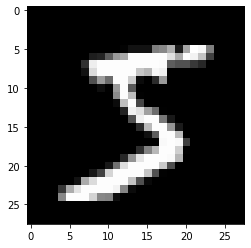

In [7]:
plt.imshow(data_train[0][0].reshape((28, 28, 1)), cmap='gray') # построение изображения
plt.show()

In [8]:
class CrossEntropyLoss:
    def __init__(self):
        self.loss = None
        self.grad = None
        self.p_pred = None
        self.p_true = None
        self.batch_size = 1
        self.classes = 1

    def calc_loss(self, p_pred, p_true) -> np.float64:
        self.batch_size = p_true.shape[0]
        self.classes = p_true.shape[1]
        loss = 0.0

        p_pred[p_pred==0.0] = 0.000001
        p_pred[p_pred==1.0] = 0.999999
        p_true[p_true==0.0] = 0.000001
        p_true[p_true==1.0] = 0.999999

        for batch in range(self.batch_size):
            loss += np.matmul(p_true[batch], np.log(p_pred[batch]))
        loss = - loss / self.batch_size

        self.loss = loss
        self.grad = np.zeros(shape=(self.batch_size, self.classes))
        self.p_pred = p_pred
        self.p_true = p_true
        return loss
    

    def backward(self) -> np.ndarray:
        for batch in range(self.batch_size):
            self.grad[batch] = -(self.p_true[batch]/self.p_pred[batch]) + (1-self.p_true[batch])/(1-self.p_pred[batch])
        return self.grad

In [12]:
class ReLU():
    def __init__(self):
        self.prev_input = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.prev_input = x.copy()
        x[x<0] = 0.0
        return x
    

    def backward(self, grad: np.ndarray) -> np.ndarray:
        grad[self.prev_input < 0] = 0
        return grad

In [13]:
class Softmax():
    def __init__(self):
        self.prev_input = None
        self.prev_out = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        prob = np.exp(x)

        for batch in range(prob.shape[0]):
            prob[batch] = prob[batch] / prob[batch].sum()
        self.prev_out = prob.copy()
        return prob
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        return grad * self.prev_out * (1 - self.prev_out)

In [25]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features

        self.prev_input = None

        self.W = np.random.uniform(low=-0.5, high=0.5, size=(in_features, out_features))
        self.bias = np.random.uniform(low=-0.5, high=0.5, size=(out_features))


    def forward(self, x):
        self.prev_input = x.copy()

        res = np.matmul(x, self.W)
        res = np.add(res, self.bias)
        return res
        
    
    def backward(self, grad: np.ndarray, lr: np.float64=0.0001):
        grad_W = np.matmul(self.prev_input.T, grad)

        self.W = self.W - lr * grad_W

        grad_b = grad
        self.bias = self.bias - lr * grad_b.sum(axis=0)/grad_b.shape[0]
        
        grad = np.matmul(grad, self.W.T)

        return grad 

In [32]:
class CustomNetwork():
    def __init__(self, in_features, out_features):
        self.linear1 = Linear(in_features, int(in_features/4))
        self.activation = ReLU()
        self.linear2 = Linear(int(in_features/4), 10)
        self.softmax = Softmax()
        self.layers = []
        self.layers.append(self.linear1)
        self.layers.append(self.activation)
        self.layers.append(self.linear2)
        self.layers.append(self.softmax)


    def forward(self, x: np.ndarray) -> np.ndarray:
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        for layer in self.layers:
            x = layer.forward(x)
        return x
    

    def backward(self, grad) -> None:
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

In [33]:
def train(model, epochs: np.int64, train_loader, loss_func, num_classes: np.int64) -> list:
    losses = [0.0] * epochs
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            p_true = np.zeros(shape=(train_loader.batch_size, num_classes))
            target  = target.numpy()
            for batch, t in enumerate(target):
                p_true[batch][t] = 1.0

            data = data.numpy()

            p_pred = model.forward(data)

            loss = loss_func.calc_loss(p_pred, p_true)
            losses[epoch] += loss/len(train_loader)

            grad = loss_func.backward()
            model.backward(grad)
        print(f"loss on epoch {epoch+1}:\t {losses[epoch]}")
    return losses

In [34]:
num_classes = 10
epochs = 20
model = CustomNetwork(in_features=np.prod(data_train[0][0].shape), out_features=num_classes)
loss_func = CrossEntropyLoss()
losses = train(model=model, epochs=epochs, train_loader=train_loader, loss_func=loss_func, num_classes=num_classes)

loss on epoch 1:	 2.6380331034152253
loss on epoch 2:	 1.011849330571753
loss on epoch 3:	 0.7349360052502075
loss on epoch 4:	 0.5871664277773986
loss on epoch 5:	 0.4928736986717646
loss on epoch 6:	 0.4268810127813011
loss on epoch 7:	 0.3779582184075165
loss on epoch 8:	 0.3400713115032216
loss on epoch 9:	 0.3096388908423677
loss on epoch 10:	 0.2846235510553983
loss on epoch 11:	 0.2637072138038387
loss on epoch 12:	 0.2459514360380574
loss on epoch 13:	 0.2307106451172708
loss on epoch 14:	 0.21743444204195353
loss on epoch 15:	 0.2057736938746618
loss on epoch 16:	 0.1954657812644416
loss on epoch 17:	 0.18629980230381915
loss on epoch 18:	 0.17812990267322323
loss on epoch 19:	 0.17079311818929008
loss on epoch 20:	 0.16413475183108678


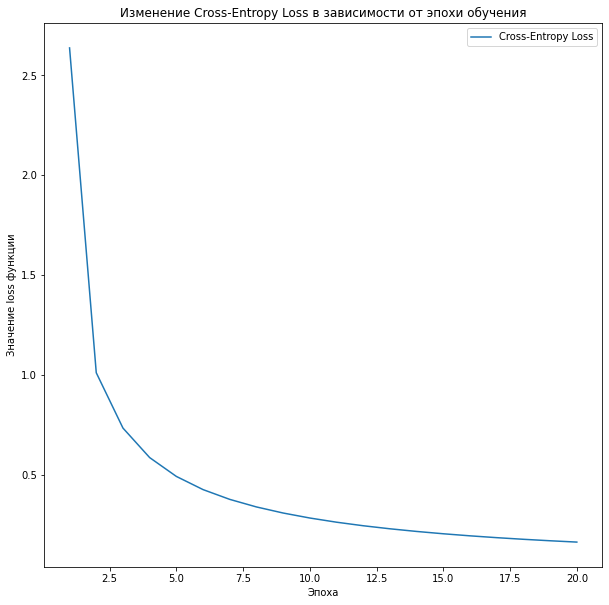

In [35]:
plt.figure(figsize=(10,10))
plt.title("Изменение Cross-Entropy Loss в зависимости от эпохи обучения")
plt.plot(range(1, epochs+1), losses, label="Cross-Entropy Loss")
plt.xlabel("Эпоха")
plt.ylabel("Значение loss функции")
plt.legend()
plt.show()

In [41]:
def evaluate_accuracy(model, eval_loader) -> float:
    samples_num = len(eval_loader.dataset)
    labels_true = []
    labels_pred = []
    
    for batch_idx, (data, target) in enumerate(eval_loader):
        target  = target.numpy()
        for t in target:
            labels_true.append(t)

        data = data.numpy()

        preds = model.forward(data)
        preds = preds.argmax(axis=-1)
        for pred in preds:
            labels_pred.append(pred)
    
    correct_predictions = 0
    all_predictions = samples_num
    for i in range(samples_num):
        if labels_pred[i] == labels_true[i]:
            correct_predictions += 1
    accuracy = correct_predictions/all_predictions
    return accuracy

In [43]:
evaluate_accuracy(model=model, eval_loader=train_loader)

0.957